In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from utils import set_seed
import sys
set_seed(3407)
import pylab as plt
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

2024-04-30 15:20:57.325358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 15:20:57.503212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-30 15:20:57.503232: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-30 15:20:58.141480: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
import pickle

class TabularRegressionData(Dataset):
    """ 
    Simple tabular data with 5 numerical features and 1 numerical response. 
    """

    def __init__(self, split, dimensions = 5):
        assert split in {'train', 'test'}
        self.split = split
        self.dimensions = dimensions
        
    def __len__(self):
        return 10000 # ...
    
    def __getitem__(self, idx):
        x = torch.randn(5)
        y = -3.15 + x[0] + (2 * x[2] * x[3]) - 3 * (x[4]**3)
        w = torch.rand(1)
        return x, y, w


In [3]:
class CSVLoader(Dataset):
    def __init__(self, file_path, feature_cols, target_col, dimensions = 5):
        """
        Args:
            file_path (str): Path to the CSV file.
            feature_cols (list of str): List of column names to be used as features.
            target_col (str): Column name of the target variable.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(file_path)
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.dimensions = dimensions
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        features = torch.tensor(self.data_frame.loc[idx, self.feature_cols].values.astype('float32'))
        target = torch.tensor(self.data_frame.loc[idx, self.target_col], dtype = torch.float32)
        return features, target



In [4]:
# print an example instance of the dataset
train_dataset = TabularRegressionData('train')
test_dataset = TabularRegressionData('test')
x, y, w = train_dataset[0]
print(x, y, w)
x1, y1, w1 = test_dataset[0]
print(x1, y1, w1)


tensor([ 1.0971,  0.5328, -0.3311, -0.4458,  0.6679]) tensor(-2.6515) tensor([0.1637])
tensor([ 0.7001, -1.3740,  0.8256, -0.8355, -2.0480]) tensor(21.9389) tensor([0.4118])


In [5]:
len(train_dataset), len(test_dataset)

(10000, 10000)

In [6]:
sys.getsizeof(train_dataset), sys.getsizeof(test_dataset)

(48, 48)

In [7]:
x1.dtype, x.dtype, y1.dtype, y.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [8]:
# create a GPT instance
from model_ff import ffmodel
model_config = ffmodel.get_default_config()
model_config.input_size = 5
model_config.use_dropout = True
model_config.p_drop = 0.1
model = ffmodel(model_config)

In [9]:
# create a Trainer object
from trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 3e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 4
train_config.batch_size = 100
train_config.eval_iters = 100
train_config.resume = False
train_config.checkpoint_path = '/home/suhas/research/dl/checkpoints/'
trainer = Trainer(train_config, model, train_dataset, test_dataset)

running on device cpu


In [10]:
# def batch_end_callback(trainer):
#     if trainer.iter_num % 100 == 0:
#         print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        
# #trainer.set_callback('on_batch_end', batch_end_callback)

In [11]:
trainer.run()

iter_num 100  train_loss: 71.23667907714844 , test_loss:  78.24456787109375 , last batch loss: 61.6900634765625
iter_num 200  train_loss: 77.408203125 , test_loss:  72.26527404785156 , last batch loss: 40.255455017089844
iter_num 300  train_loss: 71.95394134521484 , test_loss:  63.61396026611328 , last batch loss: 61.95376968383789
iter_num 400  train_loss: 68.21039581298828 , test_loss:  68.12724304199219 , last batch loss: 43.23558807373047
iter_num 500  train_loss: 65.35712432861328 , test_loss:  67.5605239868164 , last batch loss: 35.0493049621582
Directory already exists at /home/suhas/research/dl/checkpoints/
Checkpoint saved at iter 500
iter_num 600  train_loss: 56.24153518676758 , test_loss:  61.412017822265625 , last batch loss: 13.596185684204102
iter_num 700  train_loss: 56.943058013916016 , test_loss:  57.534934997558594 , last batch loss: 34.33395004272461
iter_num 800  train_loss: 45.77349853515625 , test_loss:  49.17228698730469 , last batch loss: 32.924251556396484
iter

In [12]:
dftrain = pd.DataFrame(trainer.train_losses)
dftrain.columns = ['batches','loss']

dftest = pd.DataFrame(trainer.test_losses)
dftest.columns = ['batches','loss']

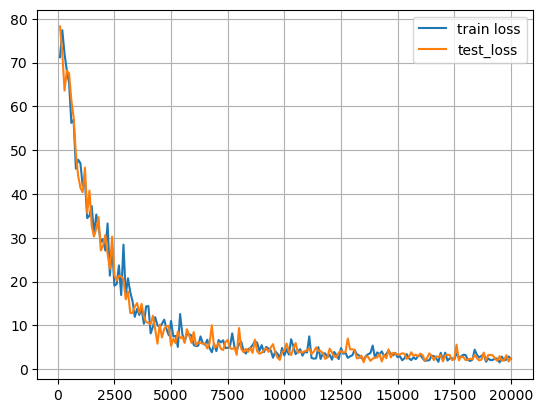

In [13]:
plt.plot(list(dftrain.batches), list(dftrain.loss))
plt.plot(list(dftest.batches), list(dftest.loss))
plt.legend(['train loss','test_loss'])
plt.grid()